Note: For full notebook, output, and data, see the original Kaggle notebook at https://www.kaggle.com/code/lccburk/millikan-oil-drop-experiment-data-analysis/notebook

# The Millikan Oil Drop Experiment
In this experiment performed in my Physics lab class my partner and I use tiny droplets of oil in an electric field to measure the value of the elementary electric charge.

## Introduction
The Millikan oil drop experiment is a famous physics experiment first performed in 1909 by Robert A. Millikan and Harvey Fletcher to measure the elementary electric charge $e$. The experiment consists of measuring the rise and fall velocities of tiny droplets of oil in an electric field. These droplets are so small that in the absence of an external force they reach their terminal fall velocity almost instantly. By ionizing these droplets with an alpha radiation source we can give them a small positive charge, so that when we switch on an electric field we can cause them to rise with a velocity proportional to their charge. 

Stoke's Law gives the frictional force exerted on spherical objects with very small Reynolds numbers in a viscous fluid – like our oil droplet moving through air. At terminal velocity the force of gravity is balanced against the frictional force of the air, and since we know both the gravitational constant $g$ and the coefficient of friction for air $k$ (as a function of air pressure and temperature), by measuring the terminal velocity $v_f$ of the droplet we can use Stoke's Law to solve for its mass. With its mass known, we can measure the total charge of the droplet by observing its motion in an applied electric field of a known strength. We can even change the charge of a single droplet by reionizing it and observing its change in velocity. Once we have collected enough data, **we expect to find that the measured charge values of the droplets are integer multiples of some elementary constant.**

In his original experiment Millikan obtained his velocity measurements by watching these oil droplets move up and down and measuring the time they took to move a known distance. This is no easy task. One must peer through a backlit microscope lens and keep their eye trained on a single microscopic droplet for as long as they can bear, or until it loses its charge and falls out of view. After attempting this classic method for about 20 minutes I decided it wasn't worth losing vision in my right eye over and opted to make use of some of the 21st century technology Millikan lacked access to. In our version of the experiment we used an iPhone 8 camera to record footage of the droplets moving up and down. Additionally, rather than timing these droplets by hand to get their velocity data, I had the idea to automate this as well by motion tracking the droplet footage using one of my all time favorite pieces of open source software, Blender. The tracking went beautifully, and this is primary dataset we will be using in this analysis. 

# Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit as fit
from skimage import io
%matplotlib inline

## Getting data into notebook
We took good footage of three separate droplets. The first lasted for about 15 minutes, the second for over 20 minutes, and the third for over 30 minutes. I'll begin by importing the tracking data for these three droplets into my notebook and taking a look at the head of the first dataset to show how they're organized

In [3]:
drop1=pd.read_csv('./Tracking data/trial1_track.csv')
drop2=pd.read_csv('./Tracking data/trial2_track.csv')
drop3=pd.read_csv('./Tracking data/trial3_track.csv')

drop1.head()

,frame,x,y
0,0,343.870983,254.205034
1,1,343.870983,254.205034
2,2,343.867979,254.118340
3,3,343.710422,253.873964
4,4,343.558016,253.735819


For each frame there is an x and y coordinate corresponding to the pixel value of the tracking marker for the given frame. One thing to note is that when importing the video file into Blender the video was rotated and the **x and y values were flipped**. So the x coordinate corresponds to the vertical direction, not the horizontal. 

# Getting Rise & Fall Velocities
## Finding peaks and valleys
The plan is to slice my dataset containing the entire journey of the particle into individual rises and falls. Then I can fit a line to each one of these segments to get the slope, and therefore the velocity. This should give me more accurate velocity measurements than simply looking at the individual turning points since it uses the entire dataset, rather than a small number of individual turning points. 

Using some blackbelt Google-fu I managed to find a peak finding algorithm in the Scipy package, which I have already imported. I'll be using this to find the peaks and valleys of my vertical position. These are the points where we turned the field off or on. 

I'll begin with the first dataset, since it is the smallest, so I can figure out the method. Then I'll move on to the more robust second and third datasets.

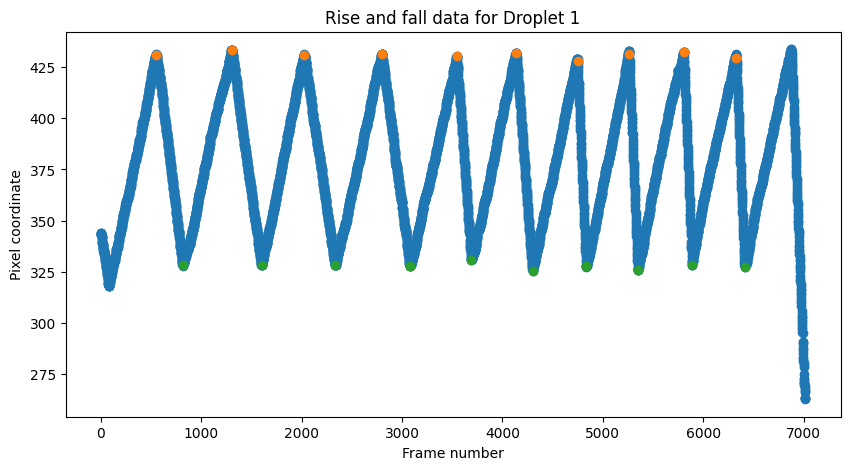

In [4]:
peak1 = signal.find_peaks_cwt(drop1['x'], np.arange(1,300)) #Finding peaks
val1 = signal.find_peaks_cwt(-drop1['x'], np.arange(1, 500)) #Finding valleys

peak1 = np.delete(peak1, [0, peak1.size-1]) # Deleting false positives
val1 = np.delete(val1, 0)

f, ax = plt.subplots(figsize=(10, 5)) #Plotting journey along with peak and valley points
ax.scatter(drop1['frame'], drop1['x'])
ax.scatter(peak1, [drop1.iloc[i]['x'] for i in peak1])
ax.scatter(val1, [drop1.iloc[i]['x'] for i in val1])
ax.set(title='Rise and fall data for Droplet 1', xlabel='Frame number', ylabel='Pixel coordinate')
plt.show()

It's not perfect, but the peak finding algorithm seems to have done its job pretty well. I had to get rid of some of the poorer datapoints, those being the first and last of the 'peaks' and the first 'valley', where the algorithm seemed to falter.

Below I have created two lists containing the indices for all of the frames where the particle is rising and all of the frames where the particle is falling. For the plot, pick a number for `num` and it will plot that particular rise and fall. *Reminder: Due to how the video was rotated, falling x values correspond to the droplet actually rising*. 

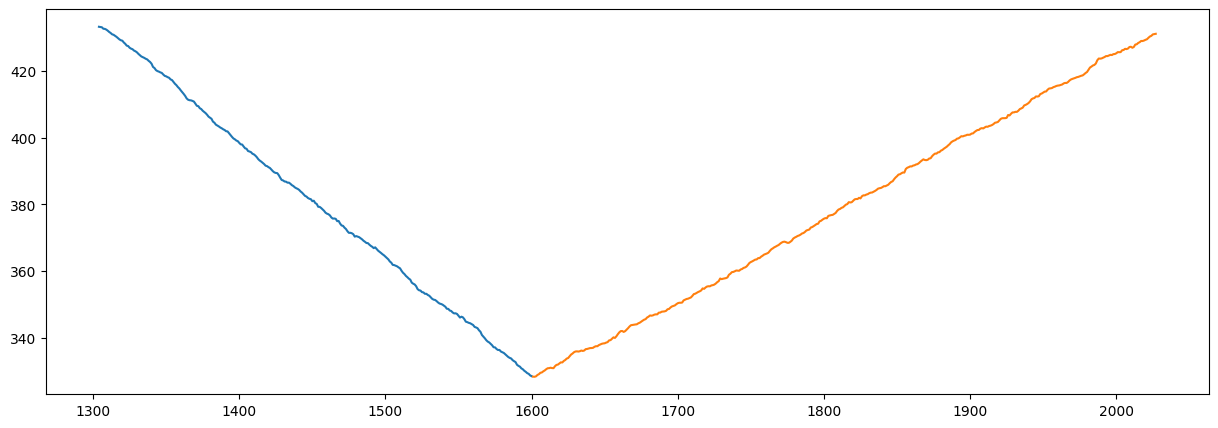

In [5]:
rises1 = [np.arange(peak1[i], val1[i]) for i in range(10)]
falls1 = [np.arange(val1[i], peak1[i+1]) for i in range(9)]

f, ax = plt.subplots(figsize=(15, 5))
num=1 # Pick a number in the range 1-10

ax.plot([drop1.iloc[i]['frame'] for i in rises1[num]], 
        [drop1.iloc[i]['x'] for i in rises1[num]])

ax.plot([drop1.iloc[i]['frame'] for i in falls1[num]], 
        [drop1.iloc[i]['x'] for i in falls1[num]])

plt.show()

## Fitting line segments to get velocities
Now that I have a way of segmenting my data, I can fit a simple line to each one of these segments and record the slope for each fit. First I'll need to create a linear function to be fitted. This will take as its input a droplet dataframe and list of frames corresponding to a given rise or fall, and it will output the slope of that segment.

In [6]:
def linefit(df, rang): 
    popt, pcov = fit(lambda x, a, b: a*x+b, [df.iloc[i]['frame'] for i in rang], [df.iloc[i]['x'] for i in rang])
    return popt[0]

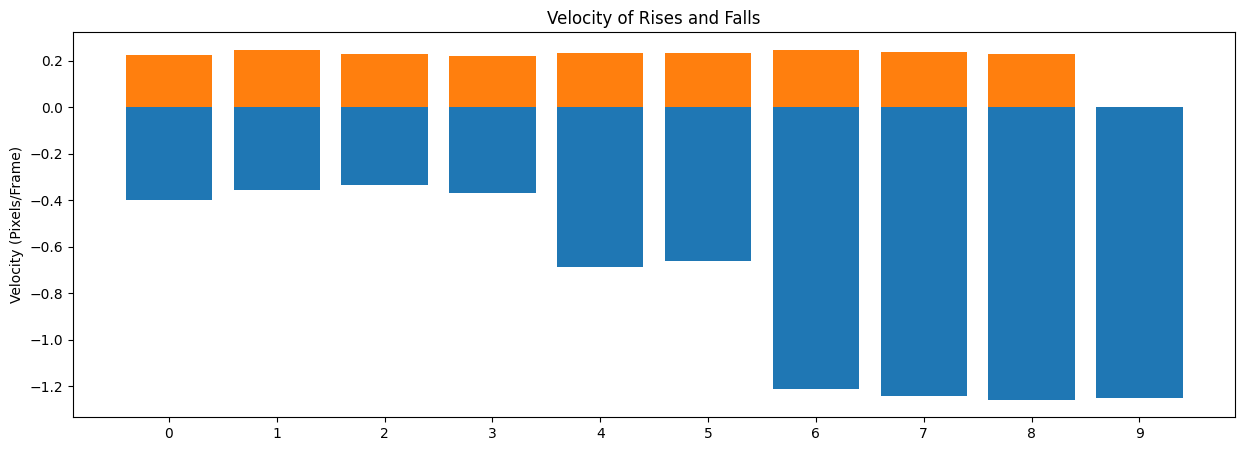

In [7]:
rises1[1].shape
vup1 = [linefit(drop1, rises1[i]) for i in range(len(rises1))]
vdown1 = [linefit(drop1, falls1[i]) for i in range(len(falls1))]

f, ax = plt.subplots(figsize = (15, 5))
ax.bar(np.arange(len(vup1)), vup1)
ax.bar(np.arange(len(vdown1)), vdown1)
ax.set(title = 'Velocity of Rises and Falls', xticks=np.arange(10), ylabel='Velocity (Pixels/Frame)')
plt.show()

Now we're talking! We clearly see the predicted behavior. The fall velocity (the positive values in the graph) remain basically steady throughout the experiment, while the rise velocity rises stepwise, demonstrated expected behaviour for discrete units of charge increase. 

## Repeating method with other two datasets
### Second droplet
Before I continue on with this dataset, let's take a look at the other two, larger datasets to see if we see this same trend.

In [8]:
peak2 = signal.find_peaks_cwt(drop2['x'], np.arange(1, 700))
val2 = signal.find_peaks_cwt(-drop2['x'], np.arange(1, 700))

# Getting rid of outliers
peak2 = np.delete(peak2, [9, 19, peak2.size-1])
val2 = np.delete(val2, [9, 19])

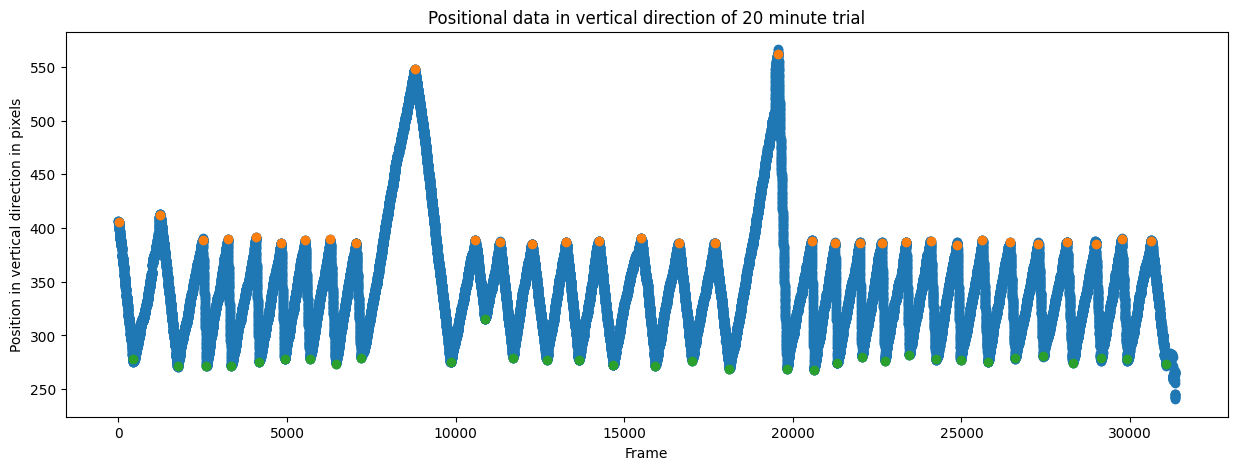

In [9]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(drop2['frame'], drop2['x'])
ax.scatter(peak2, [drop2.iloc[i]['x'] for i in peak2])
ax.scatter(val2, [drop2.iloc[i]['x'] for i in val2])
ax.set(title='Positional data in vertical direction of 20 minute trial', 
       ylabel='Position in vertical direction in pixels', 
       xlabel='Frame')
plt.show()

Pretty nice looking peaks once the outliers have been removed! I'll use the same code from above to allow myself to look at the individiual rises and falls more closeley. Then I will use the `linefit` function to get some velocities out of this data and see how they look.

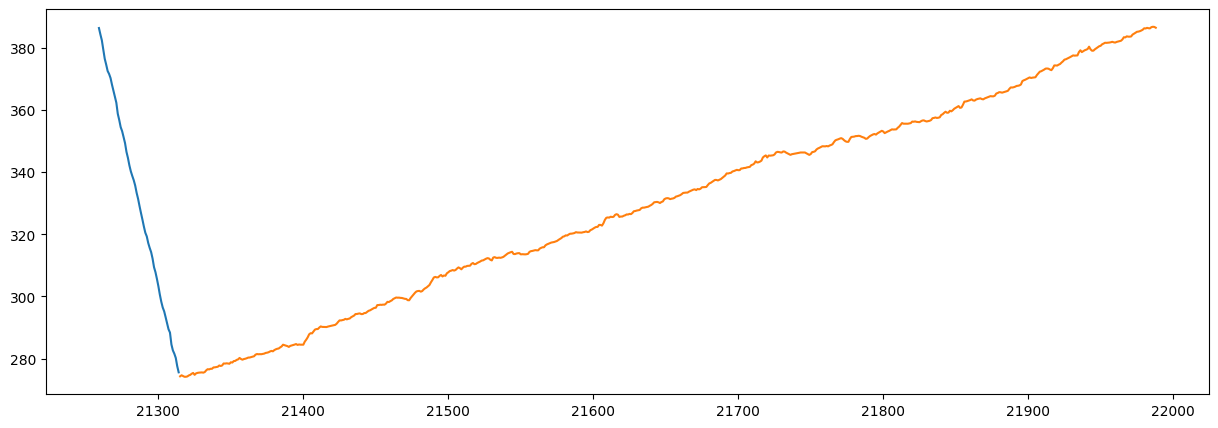

In [10]:
rises2 = [np.arange(peak2[i], val2[i]) for i in range(len(peak2))]
falls2 = [np.arange(val2[i], peak2[i+1]) for i in range(len(peak2)-1)]

f, ax = plt.subplots(figsize=(15, 5))
num = 20 #Max num is 32

ax.plot([drop2.iloc[i]['frame'] for i in rises2[num]], [drop2.iloc[i]['x'] for i in rises2[num]])
ax.plot([drop2.iloc[i]['frame'] for i in falls2[num]], [drop2.iloc[i]['x'] for i in falls2[num]])
plt.show()

In [11]:
def linefit(df, rang): 
    popt, pcov = fit(lambda x, a, b: a*x+b, [df.iloc[i]['frame'] for i in rang], [df.iloc[i]['x'] for i in rang])
    return popt[0], np.sqrt(pcov[0,0]*pcov[0,0])

In [12]:
vup2 = [linefit(drop2, rises2[i])[0] for i in range(len(rises2))]
vuperr2 = [linefit(drop2, rises2[i])[1] for i in range(len(rises2))]
vdown2 = [linefit(drop2, falls2[i])[0] for i in range(len(falls2))]
vdownerr2 = [linefit(drop2, falls2[i])[1] for i in range(len(falls2))]

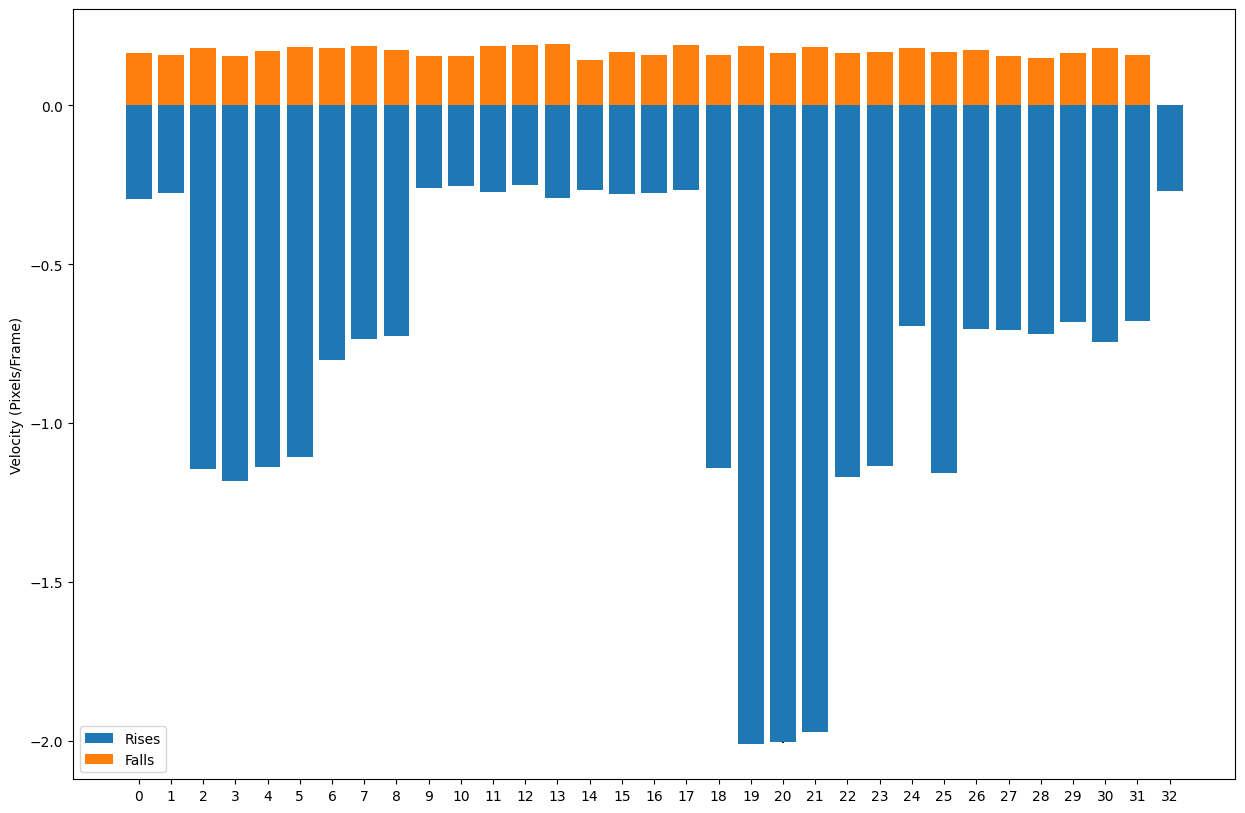

In [13]:
f, ax = plt.subplots(figsize = (15, 10))
ax.bar(np.arange(len(vup2)), vup2, yerr = vuperr2)
ax.bar(np.arange(len(vdown2)), vdown2, yerr = vdownerr2)
ax.set(ylabel='Velocity (Pixels/Frame)', xticks=np.arange(len(vup2)))
ax.legend(['Rises', 'Falls'])
plt.show()

While the fall velocity appears to vary a bit more than it did in the last dataset, it still remains around some constant value. We again see the discrete behavior of the rising velocities. 

### Third Dataset
Now to repeat the process once more for the third dataset.

In [14]:
peak3a = signal.find_peaks_cwt(drop3['x'], np.arange(1, 700))
val3a = signal.find_peaks_cwt(-drop3['x'], np.arange(1, 700))
#The 'a' at the end is to differentiate these peaks and valleys from the
#corrected peaks and valleys which I will create later, which have the 
#outliers removed. This way if I run that code again it wont remove values
#that I want to keep.

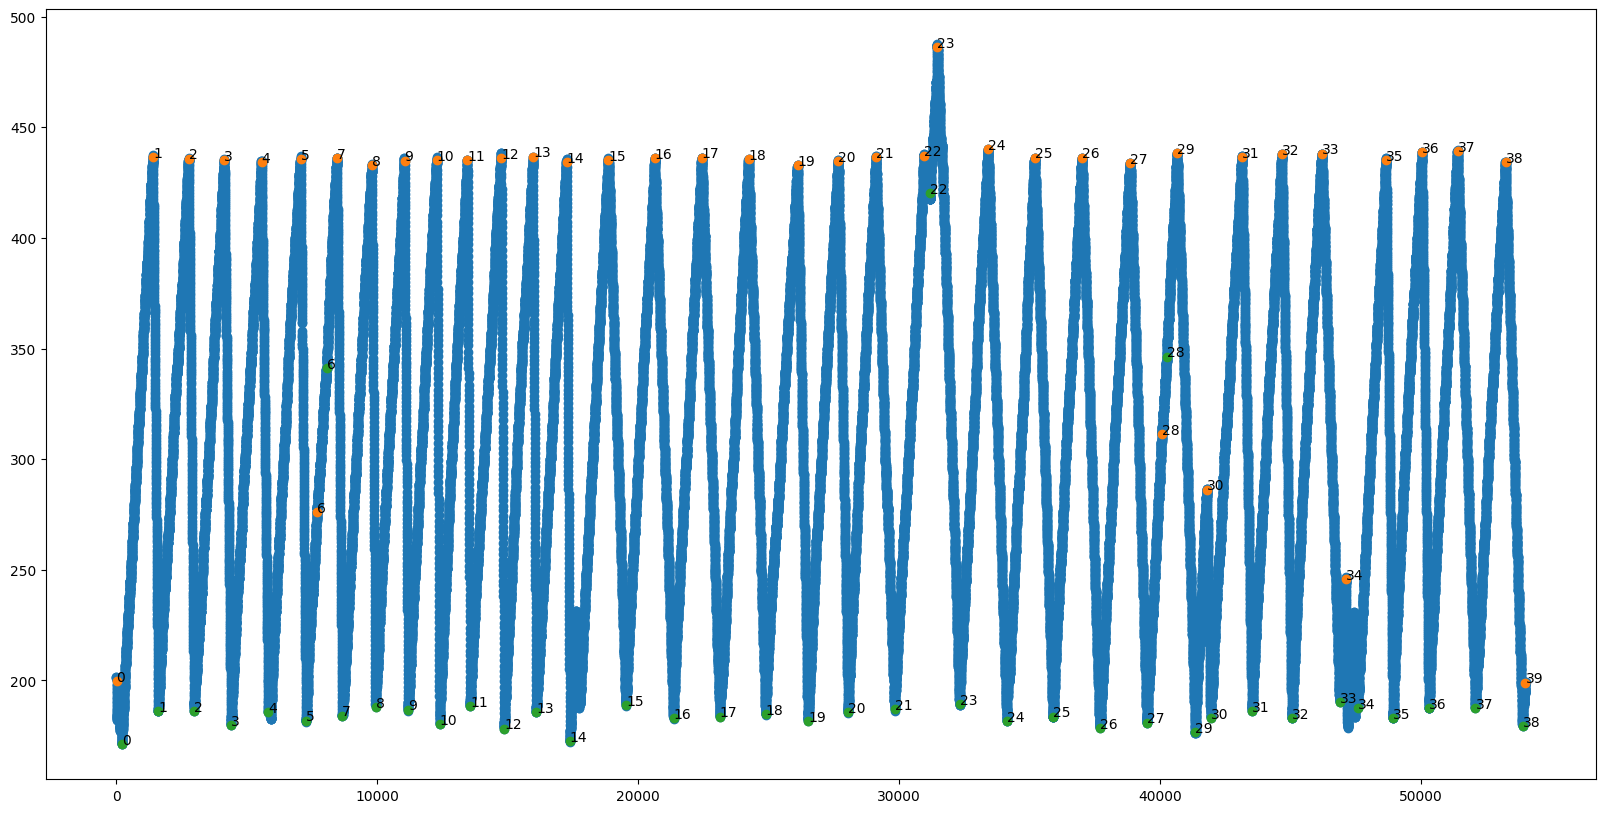

In [15]:
f, ax = plt.subplots(figsize=(20, 10))
ax.scatter(drop3['frame'], drop3['x'])
ax.scatter(peak3a, [drop3.iloc[i]['x'] for i in peak3a])
ax.scatter(val3a, [drop3.iloc[i]['x'] for i in val3a])

for i in range(len(peak3a)): 
    ax.annotate('{0}'.format(i), xy=(peak3a[i], drop3.iloc[peak3a[i]]['x']))
for i in range(len(val3a)): 
    ax.annotate('{0}'.format(i), xy=(val3a[i], drop3.iloc[val3a[i]]['x']))

This dataset is both larger and a bit messier than the previous two, so I've numbered the points on the graph to make things easier on myself. The obvious points I'll have to get rid of are index numbers 6 and 28 for both the rise and fall groups. There is also some strange behaviour around 14 and 34. I'll begin by removing the obvious ones, and then after calculating the velocities I'll remove the velocities which are innacurate due to erratic tracker behaviour.

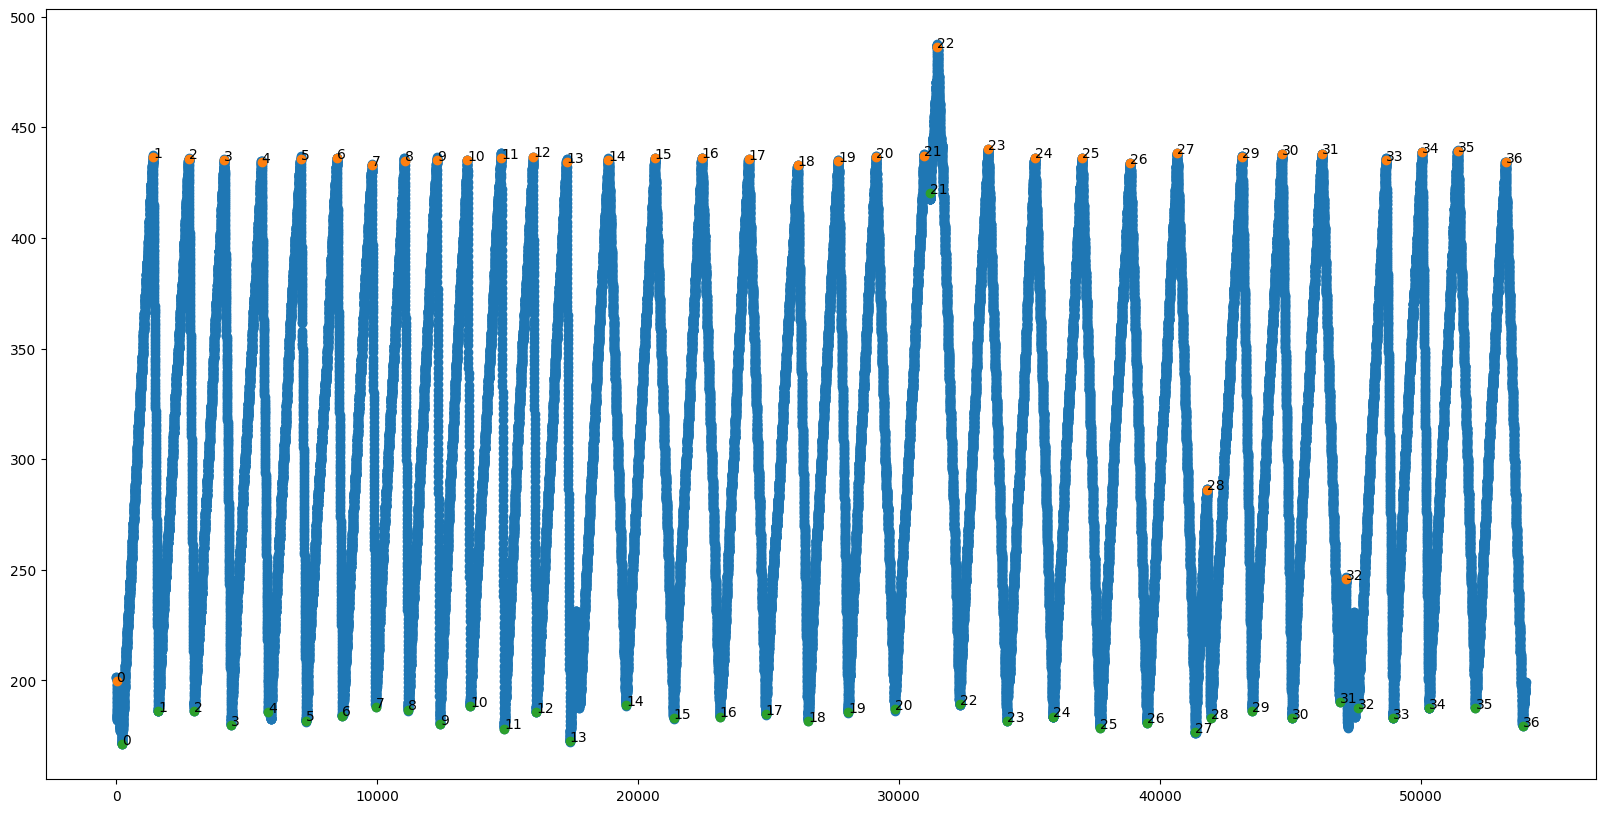

In [16]:
peak3 = np.delete(peak3a, [6, 28, len(peak3a)-1])
val3 = np.delete(val3a, [6, 28])

f, ax = plt.subplots(figsize = (20, 10))
ax.scatter(drop3['frame'], drop3['x'])
ax.scatter(peak3, [drop3.iloc[i]['x'] for i in peak3])
ax.scatter(val3, [drop3.iloc[i]['x'] for i in val3])

for i in range(len(peak3)): 
    ax.annotate('{0}'.format(i), xy=(peak3[i], drop3.iloc[peak3[i]]['x']))
for i in range(len(val3)): 
    ax.annotate('{0}'.format(i), xy=(val3[i], drop3.iloc[val3[i]]['x']))

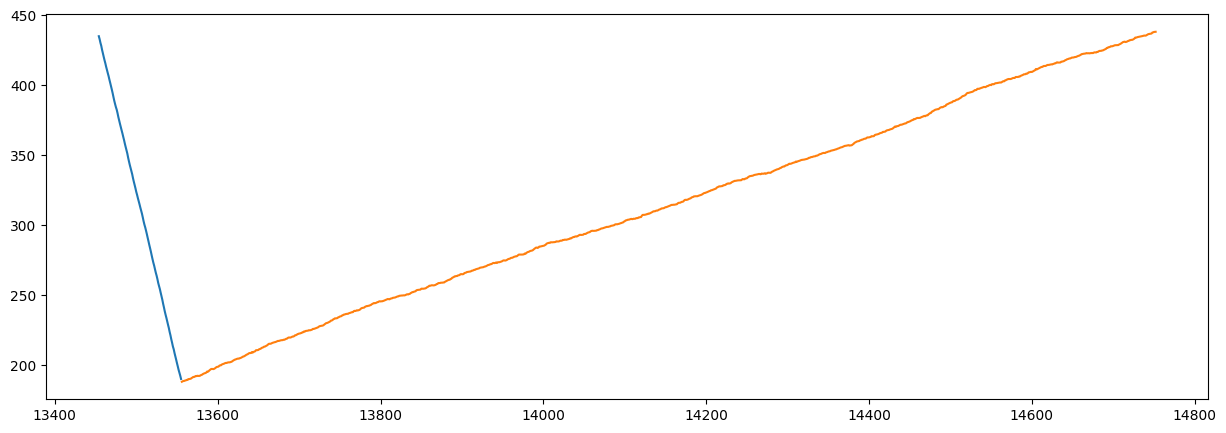

In [17]:
rises3 = [np.arange(peak3[i], val3[i]) for i in range(len(peak3))]
falls3 = [np.arange(val3[i], peak3[i+1]) for i in range(len(peak3)-1)]

f, ax = plt.subplots(figsize=(15, 5))
num= 10 # Change to view different rises/falls
ax.plot([drop3.iloc[i]['frame'] for i in rises3[num]], [drop3.iloc[i]['x'] for i in rises3[num]])
ax.plot([drop3.iloc[i]['frame'] for i in falls3[num]], [drop3.iloc[i]['x'] for i in falls3[num]])
plt.show()

In [18]:
vup3 = [linefit(drop3, rises3[i])[0] for i in range(len(rises3))]
vdown3 = [linefit(drop3, falls3[i])[0] for i in range(len(falls3))]

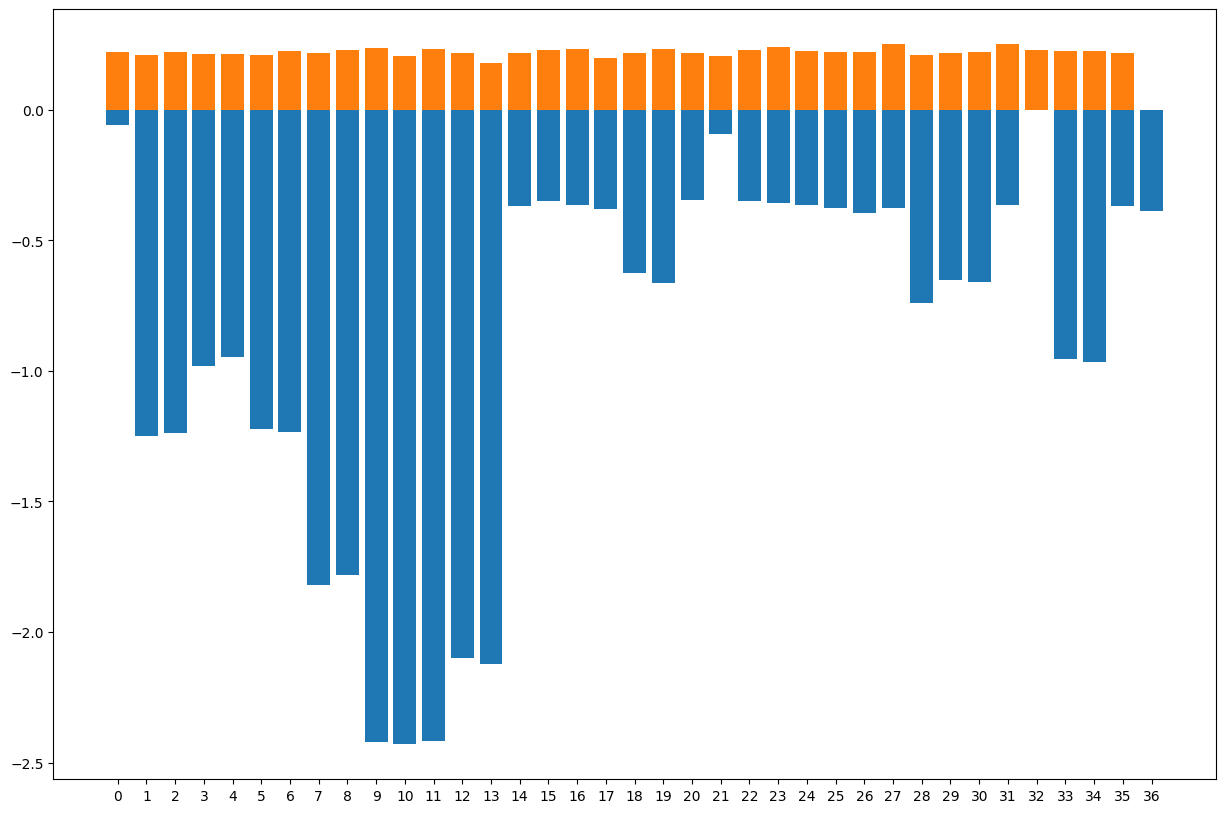

In [19]:
f, ax = plt.subplots(figsize = (15, 10))
ax.bar(np.arange(len(vup3)), vup3)
ax.bar(np.arange(len(vdown3)), vdown3)
ax.set(xticks=np.arange(len(vup3)))
plt.show()

# Getting Uncertainty Data
## Finding average width of the droplet
I would like to use Scikit to automate the random sampling and measurement of the droplet dimensions. I'll start with a single image from my second trial dataset just to get my feet wet with this new toolkit. 

I will be randomly selecting images from the image sets of the trials and using the tracking data to locate the vicinity of the droplet in the image. Then I will hopefully be able to measure the size of the droplet from this image data.

### Second dataset
One thing to note is that my image set contains all of the frames from the footage we took, but the tracking data does not begin from the first frame. For the first set of data, the tracking does not begin until the 678th frame, so when retrieving the coordinates I must make sure to account for this shift. 

In [48]:
# Note: This code requires Trial 2 Images dataset, which can be found on Kaggle at https://www.kaggle.com/datasets/lccburk/trial-2-image-set
frame = 20
im = io.imread('../input/trial-2-image-set/trial 2 image set/Trial 2 Image Set/{0}{1}.jpg'.format('0'*(4-len(str(frame+678))), frame+678))
pat = im[-int(drop2.iloc[frame]['y'])-10:-int(drop2.iloc[frame]['y'])+10, int(drop2.iloc[frame]['x'])-10:int(drop2.iloc[frame]['x'])+10]

pat[pat<0.6*pat.max()]=0 # Mask value
plt.imshow(pat)
plt.colorbar()
plt.show()

After playing around with the index values for a while, I've at last managed to pull up the coordinates of the droplet for a given frame and display the area of the Blender tracking box. This 20x20 area is the marker 'pattern', or box which gets displayed in the UI to help find the tracker (the actual pattern box is 21x21 close enough). Since the droplet moves so slowly it never actual leaves this box for any given frame, so its a great area to limit my size calculations to.

By adjusting the above mask we can constrain the displayed values to ones above some lower limit. Changing the `frame` value displays the droplet for different frames. Experimenting with these two parameters, I found that a mask value of 60% of the maximum pixel value did the best job of isolating the droplet in the image. By measuring the standard deviation of these pixels away from the recorded tracking point I should be able to get a very good value for the uncertainty of my positional data.

In [ ]:
def track2_std(frame):
    im = io.imread('../input/trial-2-image-set/trial 2 image set/Trial 2 Image Set/{0}{1}.jpg'.format('0'*(4-len(str(frame+678)))*(len(str(frame+678))<5), frame+678))
    pat = im[-int(drop2.iloc[frame]['y'])-10:-int(drop2.iloc[frame]['y'])+10, int(drop2.iloc[frame]['x'])-10:int(drop2.iloc[frame]['x'])+10]
    y, x = np.where(pat > 0.6*pat.max())
    stdx = np.sqrt(np.mean(np.array([(i-10)*(i-10) for i in x])))
    stdy = np.sqrt(np.mean(np.array([(i-10)*(i-10) for i in y])))
    return stdx, stdy

The above function takes as its input a frame number and outputs the standard deviation in the x and y directions of the pixels in the tracking pattern with values greater than 60 away from the recorded tracking coordinate for the frame (for the second data set). 

Sadly I cannot locate the Blender file I used to track the first trial set, and so I do not know which frame I started the tracking for that video. I do have the tracking file for the second and third sets though, so I should be able to get good data from those two. 

Now I need to sample my frame image data and use the standard deviation function defined above to get the average standard deviation of the droplet location from the recorded tracker value. I'll take a sample from each second of footage, or one every thirty frames.

In [ ]:
sample = np.arange(0, len(drop2), 30)

stdx = [track2_std(int(s))[0] for s in sample]
stdy = [track2_std(int(s))[1] for s in sample]

print('Standard deviation of droplet pixels from tracking point: \n Vertical direction: {0} \n Horizontal direction: {1}'.format(np.average(stdx), np.average(stdy)))

In [ ]:
f, ax = plt.subplots()
ax.hist(stdy, alpha = 0.5, bins=10)
ax.hist(stdx, alpha = 0.5, bins=10)
ax.set(title='Standard deviation of droplet pixels from tracking point', 
       xlabel='Standard deviation of droplet pixels from tracker location (pixels)', ylabel='Count number')
ax.legend(['Horizontal direction', 'Vertical direction'])
plt.show()

The standard deviation is greater in the vertical direction, which is expected given that this is the primary direction of motion for the droplet. From the histogram we can see how the horizonatl values are much more clustered around a standard deviation of two, while the vertical values are more smeared out.

Now I would like to see how these standard deviations vary with time. I'll use a scatter plot to visualize all of my sampled datapoints, and then use a bar chart to show the average standard deviation in the vertical direction over 10 second intervals (each of which should have 30 data points because I collected one sample per second).

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))

ax.scatter(sample, stdx, alpha =0.5)

num=int(drop2.frame.max()/300) # Number of bars
bins = np.linspace(0, sample.max(), num)
vals = [np.average([stdx[i] for i in np.where((sample >bins[i]) & (sample < bins[i+1]))[0]]) for i in range(len(bins)-1)]
ax.bar(left=bins[:-1], height=vals, width=(2/3)*sample.max()/num, zorder=0, align='edge')

ax.set(xlim=[0, drop2.frame.max()], ylabel='Standard deviation of droplet from tracker position', 
       xlabel='Frame number', title='Standard deviation of droplet pixels from tracking point versus frame number')
plt.show()

In [ ]:
sigma2_rise = np.array([[stdx[int(np.where((i >= sample) & (i < sample+30))[0])] for i in rises2[j]] for j in range(len(rises2))])
sigma2_fall = np.array([[stdx[int(np.where((i >= sample) & (i < sample+30))[0])] for i in falls2[j]] for j in range(len(falls2))])

In [ ]:
vup2 = [linefit(drop2, rises2[i])[0] for i in range(len(rises2))]
vuperr2 = [linefit(drop2, rises2[i])[1] for i in range(len(rises2))]
vdown2 = [linefit(drop2, falls2[i])[0] for i in range(len(falls2))]
vdownerr2 = [linefit(drop2, falls2[i])[1] for i in range(len(falls2))]

We can see from the above graph of the standard deviation of the sampled frames how the uncertainty of the tracker position varies throughout the footage. There are higher levels of variation between frames ~2500 and ~7500, and also in the final third of the footage, beginning near frame 20000. The most precise portion of the footage is the middle section, when the droplet location is very near the position of the tracker.

With this information, I should be able to get very accurate fits to my data and an idea of how precise my results are. 

### Third dataset
From the Blender file, this third tracking dataset begins at the 21st frame, so I need to shift the frame data by this number. The images in this set are darker than those of the first, and the droplet is smaller. To account for this, I used the slightly less restrictive mask value of 50% of whatever the maximum pixel value is for a given search pattern, rather than 60%.

In [ ]:
# Note: This code requires Trial 3 Images dataset, which can be found on Kaggle at https://www.kaggle.com/datasets/lccburk/trial-3-image-set
frame = 10000
im = io.imread('../input/trial-3-images/trial 3 image set/Trial 3 Image Set/{0}{1}.jpg'.format('0'*(4-len(str(frame+21))), frame+21))
pat = im[-int(drop3.iloc[frame]['y'])-10:-int(drop3.iloc[frame]['y'])+10, int(drop3.iloc[frame]['x'])-10:int(drop3.iloc[frame]['x'])+10]

pat[pat<0.5*pat.max()]=0 # Mask value
plt.imshow(pat)
plt.colorbar()
plt.show()

In [ ]:
def track3_std(frame):
    im = io.imread('../input/trial-3-images/trial 3 image set/Trial 3 Image Set/{0}{1}.jpg'.format('0'*(4-len(str(frame+21)))*(len(str(frame+21))<5), frame+21))
    pat = im[-int(drop3.iloc[frame]['y'])-10:-int(drop3.iloc[frame]['y'])+10, int(drop3.iloc[frame]['x'])-10:int(drop3.iloc[frame]['x'])+10]
    y, x = np.where(pat > 0.6*pat.max())
    stdx = np.sqrt(np.mean(np.array([(i-10)*(i-10) for i in x])))
    stdy = np.sqrt(np.mean(np.array([(i-10)*(i-10) for i in y])))
    return stdx, stdy

In [ ]:
sample = np.arange(0, len(drop3), 30)

stdx = [track3_std(int(s))[0] for s in sample]
stdy = [track3_std(int(s))[1] for s in sample]

print('Standard deviation of droplet pixels from tracking point: \n Vertical direction: {0} \n Horizontal direction: {1}'.format(np.average(stdx), np.average(stdy)))

In [ ]:
f, ax = plt.subplots()
ax.hist(stdy, alpha = 0.5)
ax.hist(stdx, alpha = 0.5)
ax.set(title='Standard deviation of droplet pixels from tracking point', 
       xlabel='Standard deviation of droplet pixels from tracker location (pixels)', ylabel='Count number')
ax.legend(['Horizontal direction', 'Vertical direction'])
plt.show()

Once again, we see that the vertical has a higher average standard deviation from the tracker position than the horizontal direction. The droplet in this trial is generally more concentrated around the tracked point for this dataset than for the last. This is a result of the smaller size of the droplet used for this trial. 

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
ax.scatter(sample, stdx, alpha =0.5)

num=int(drop3.frame.max()/300) 
bins = np.linspace(0, sample.max(), num)
vals = [np.average([stdx[i] for i in np.where((sample >bins[i]) & (sample < bins[i+1]))[0]]) for i in range(len(bins)-1)]
ax.bar(left=bins[:-1], height=vals, width=(2/3)*sample.max()/num, zorder=0, align='edge')
ax.set(xlim=[0, drop3.frame.max()], ylabel='Standard deviation of droplet from tracker position', xlabel='Frame number')
plt.show()

From looking at this sample of pixel distrubion standard deviations it seems as though this trial had a lower and more consistent tracking precision than the last one. There are a few differences of note between this graph and the last one.
- There are sampled values which have a stardard distribution of zero in the vertical direction, which was never the case for the second trial.
- The results as a whole seem much more uniform, meaning that many samples seem to have the exact same value. For smaller droplets with fewer pixels on average this is somewhat expected. 
- There is a very clear peak in the middle section where the standard deviation is larger than normal, before returning to about where it was before. 

Let's see what happens at these two extremes: unusually high and unusually low standard deviations.

In [ ]:
print('Frame with highest vertical standard deviation: #{0}'.format(int(sample[np.where(stdx == max(stdx))])))

frame = int(sample[np.where(stdx == max(stdx))])
im = io.imread('../input/trial-3-images/trial 3 image set/Trial 3 Image Set/{0}{1}.jpg'.format('0'*(4-len(str(frame+21))), frame+21))
pat = im[-int(drop3.iloc[frame]['y'])-10:-int(drop3.iloc[frame]['y'])+10, int(drop3.iloc[frame]['x'])-10:int(drop3.iloc[frame]['x'])+10]
pat[pat<0.5*pat.max()]=0 # Mask value

f, ax = plt.subplots()
plt.imshow(pat)
plt.colorbar()
plt.show()

So it appears that the tracker simply got away from the droplet a bit. Not a big problem. Let's see what happened at all the points with no standard deviation.

In [ ]:
print('Frames with lowest vertical standard deviation:\n{0}.'.format(', '.join([str(i) for i in sample[np.where(stdx == min(stdx))]])))

zeros = sample[np.where(stdx == min(stdx))]

frame = zeros[11] # Pick any number between 0 and 11

print('\nDisplaying frame #%i:' % frame)

im = io.imread('../input/trial-3-images/trial 3 image set/Trial 3 Image Set/{0}{1}.jpg'.format('0'*(4-len(str(frame+21))), frame+21))
pat = im[-int(drop3.iloc[frame]['y'])-10:-int(drop3.iloc[frame]['y'])+10, int(drop3.iloc[frame]['x'])-10:int(drop3.iloc[frame]['x'])+10]
pat[pat<0.5*pat.max()]=0 # Mask value

plt.imshow(pat)
plt.colorbar()
plt.show()

These frames are somewhat confusing to me, since most of them seem like they should have a standard x deviation of greater than zero. In any case though, it seems that their contribution to the uncertainty will be minimal, and I don't want to waste too much time focusing on this.

## Background velocity fluctuations
I now want to find out what the impact of brownian motion and other small, local forces are on the motion of the droplets. I'll do this by comparing the fluctuations in the vertical direction (x direction of the footage) to the fluctuations in the horizontal direction (y direction of the footage). In theory there should be no net forces in the horizontal direction, so the droplets random motion in this direction should give us information on what kinds of variations in velocity are considered normal in our test conditions. 

### Second Droplet
First, I'll get a simple idea of the time variation in the velocities and accelerations of the droplet in the horizontal direction by simply plotting their variations on a frame by frame basis over the course of the videos. 

Average y velocity magnitude (dy): 0.2419264531850195
Average y acceleration magnitude (dy^2): 0.3633963738956469


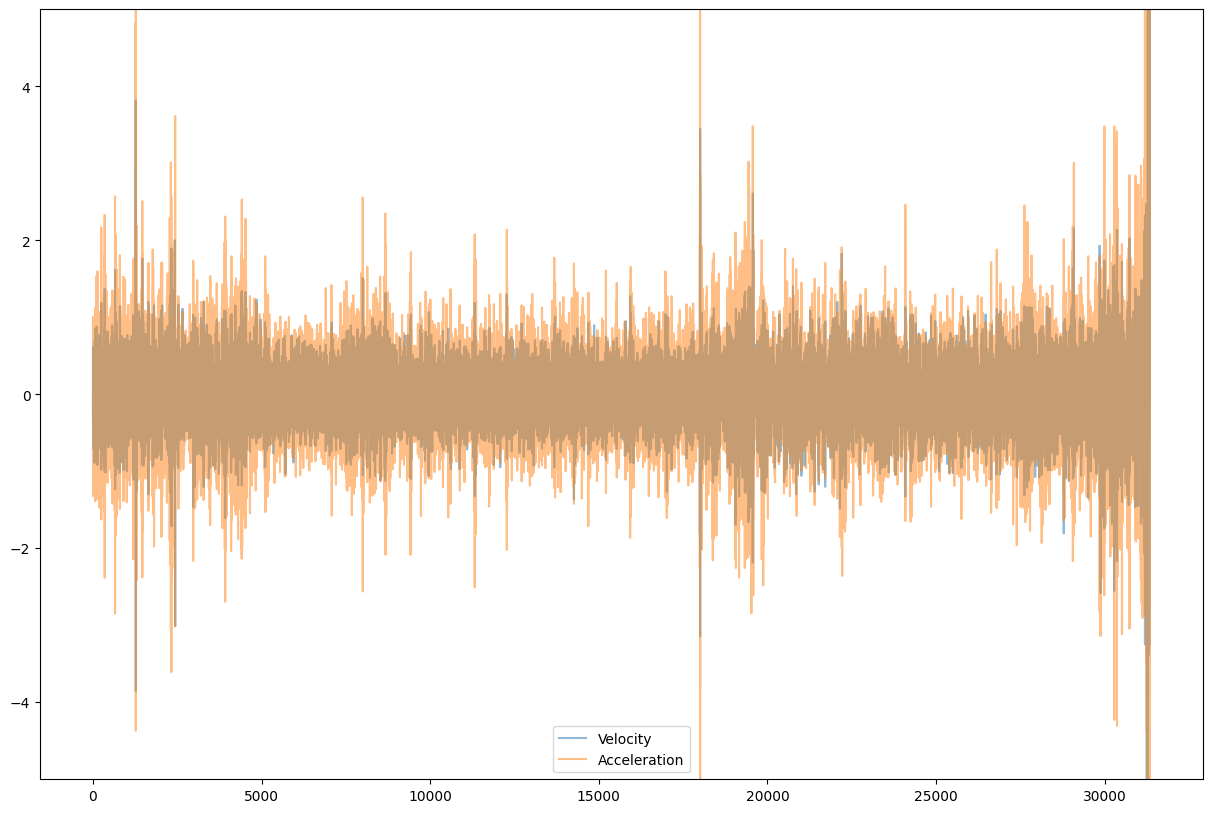

In [21]:
yvel = drop2.y.shift(-1)-drop2.y # Y velocity in one frame (dx)
# Printing average magnitude of yvel (excluding final 100 frames)
print('Average y velocity magnitude (dy): {0}'.format(np.average(np.sqrt(yvel[:-100]*yvel[:-100])))) 
f, ax = plt.subplots(figsize=(15, 10))
yacc = yvel.shift(-1)-yvel # Y acceleration over one frame (dx^2)
#Printing average magnitude of yacc (excluding final 100 frames)
print('Average y acceleration magnitude (dy^2): {0}'.format(np.average(np.sqrt(yacc[:-100]*yacc[:-100]))))
ax.plot(yvel, alpha = 0.5)
ax.plot(yacc, alpha=0.5)
ax.legend(['Velocity', 'Acceleration'])
ax.set(ylim = [-5, 5])
plt.show()

I would like to see if there are any correlations between these velocities and accelerations and the velocities I measured in the vertical direction. I'll do this by sampling the horizontal velocity and acceleration data at a rate of once per second (every 30 frames) and averaging these values over the span of each rise and fall of the droplet, using the peaks and valleys found in the previous section.

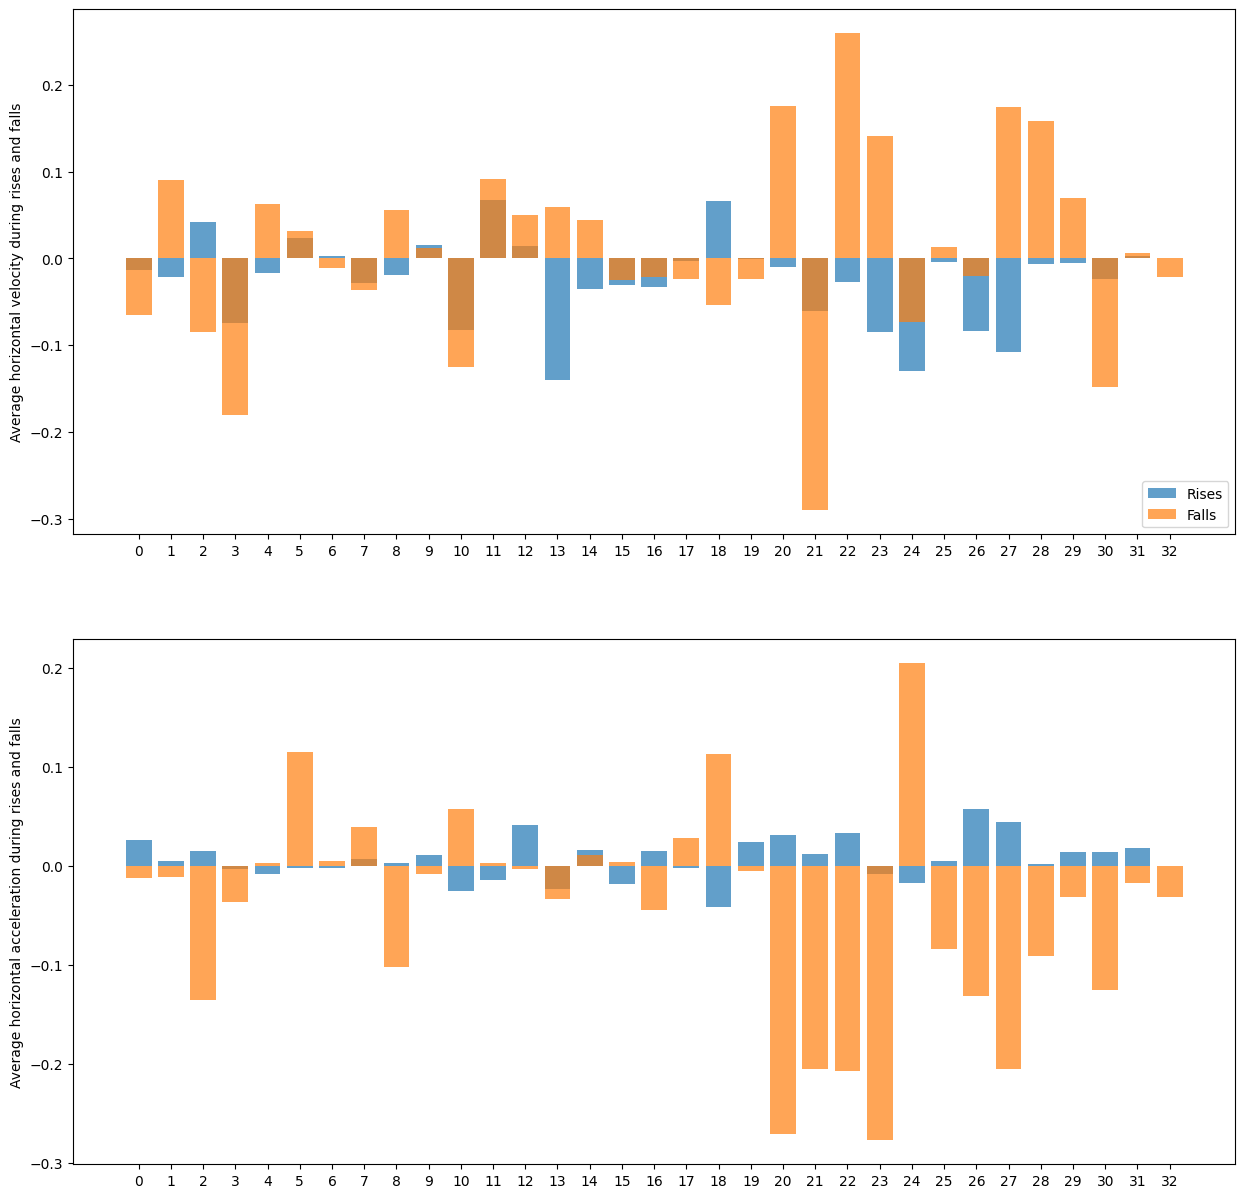

In [22]:
sample = np.arange(0, len(drop2), 30) # Sampling once per second

segments_down = [np.where((sample > peak2[i]) & (sample < val2[i])) for i in range(len(peak2))]
segments_up = [np.where((sample < peak2[i+1]) & (sample > val2[i])) for i in range(len(peak2)-1)]

vels_up=[np.average([yvel.iloc[i] for i in segments_down[arr]]) for arr in range(len(peak2))]
vels_down = [np.average([yvel.iloc[i] for i in segments_up[arr]]) for arr in range(len(peak2)-1)]

accs_up=[np.average([yacc.iloc[i] for i in segments_down[arr]]) for arr in range(len(peak2))]
accs_down = [np.average([yacc.iloc[i] for i in segments_up[arr]]) for arr in range(len(peak2)-1)]

f, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize = (15, 15))
ax1.bar(np.arange(len(vels_down)), vels_down, alpha = 0.7)
ax1.bar(np.arange(len(vels_up)), vels_up, alpha = 0.7)
ax1.set(ylabel='Average horizontal velocity during rises and falls', 
       xticks=range(len(vels_up)))
ax1.legend(['Rises', 'Falls'], loc='lower right')

ax2.bar(np.arange(len(accs_down)), accs_down, alpha = 0.7)
ax2.bar(np.arange(len(accs_up)), accs_up, alpha = 0.7)
ax2.set(ylabel='Average horizontal acceleration during rises and falls', 
        xticks= range(len(vels_up)))

plt.show()

We start seeing larger than normal accelerations and velocities in the horizontal direction at about the 20th rise/fall. At about what frame does this change occur?

In [23]:
print(peak2[20], val2[20])

21259 21315


This was a very interesting analysis, but tragically I did not find a way to incorporate these uncertainty findings into our final results. I really do believe that this form of analysis could yield very useful results and a eventually provide a way to gauge the certainty for a given velocity and charge measurement. If we had had more time in this lab I think this would have been a fruitful pursuit. At the very least, I believe this detour has succeeded in showing that the error introduced in the tracking of the particle is small, and supports our unorthodox method in this lab as being effective.

### Third droplet

Average horizontal velocity: 0.149867
Average horizontal acceleration: 0.209386


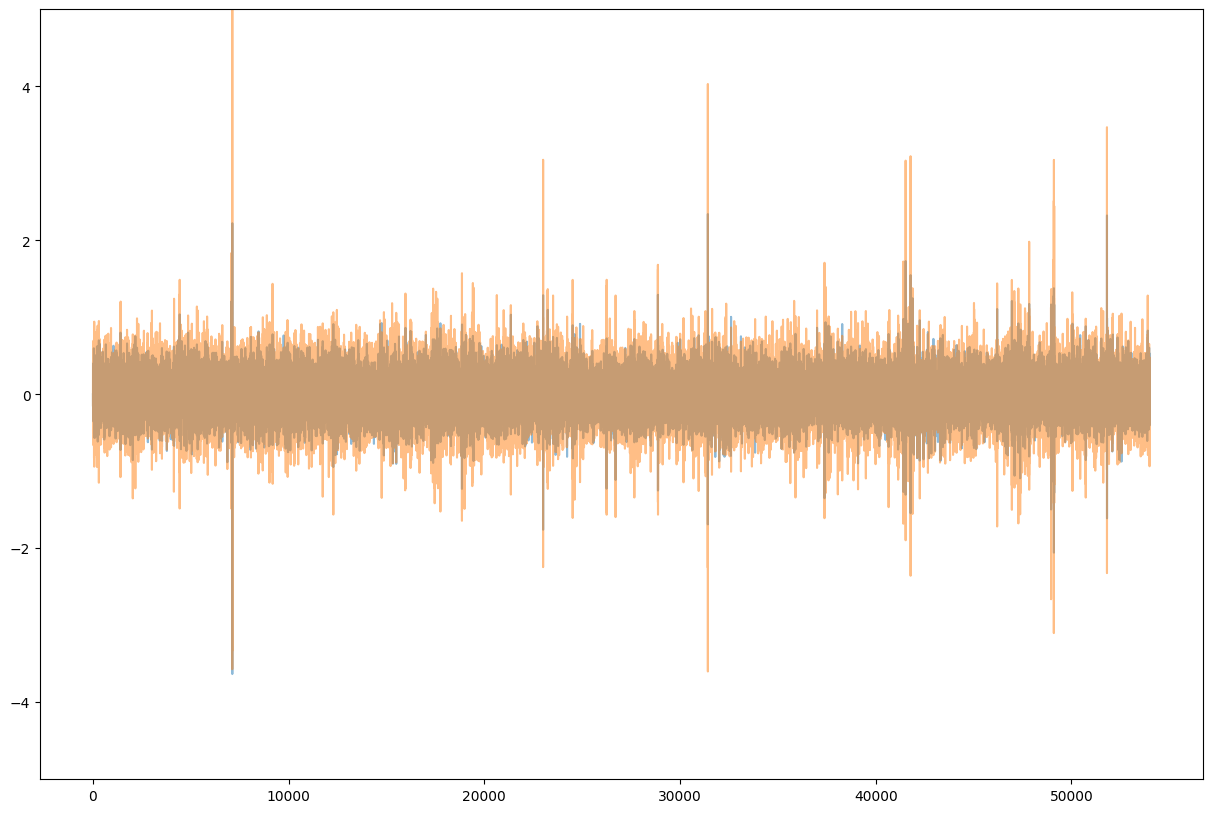

In [24]:
yvel = drop3.y.shift(-1)-drop3.y # Y velocity in one frame (dx)
# Printing average magnitude of yvel (excluding final 100 frames)
print('Average horizontal velocity: %f' % np.average(np.sqrt(yvel[:-100]*yvel[:-100]))) 
f, ax = plt.subplots(figsize=(15, 10))
yacc = yvel.shift(-1)-yvel # Y acceleration over one frame (dx^2)
#Printing average magnitude of yacc (excluding final 100 frames)
print('Average horizontal acceleration: %f' % np.average(np.sqrt(yacc[:-100]*yacc[:-100])))
ax.plot(yvel, alpha = 0.5)
ax.plot(yacc, alpha=0.5)
ax.set(ylim = [-5, 5])
plt.show()

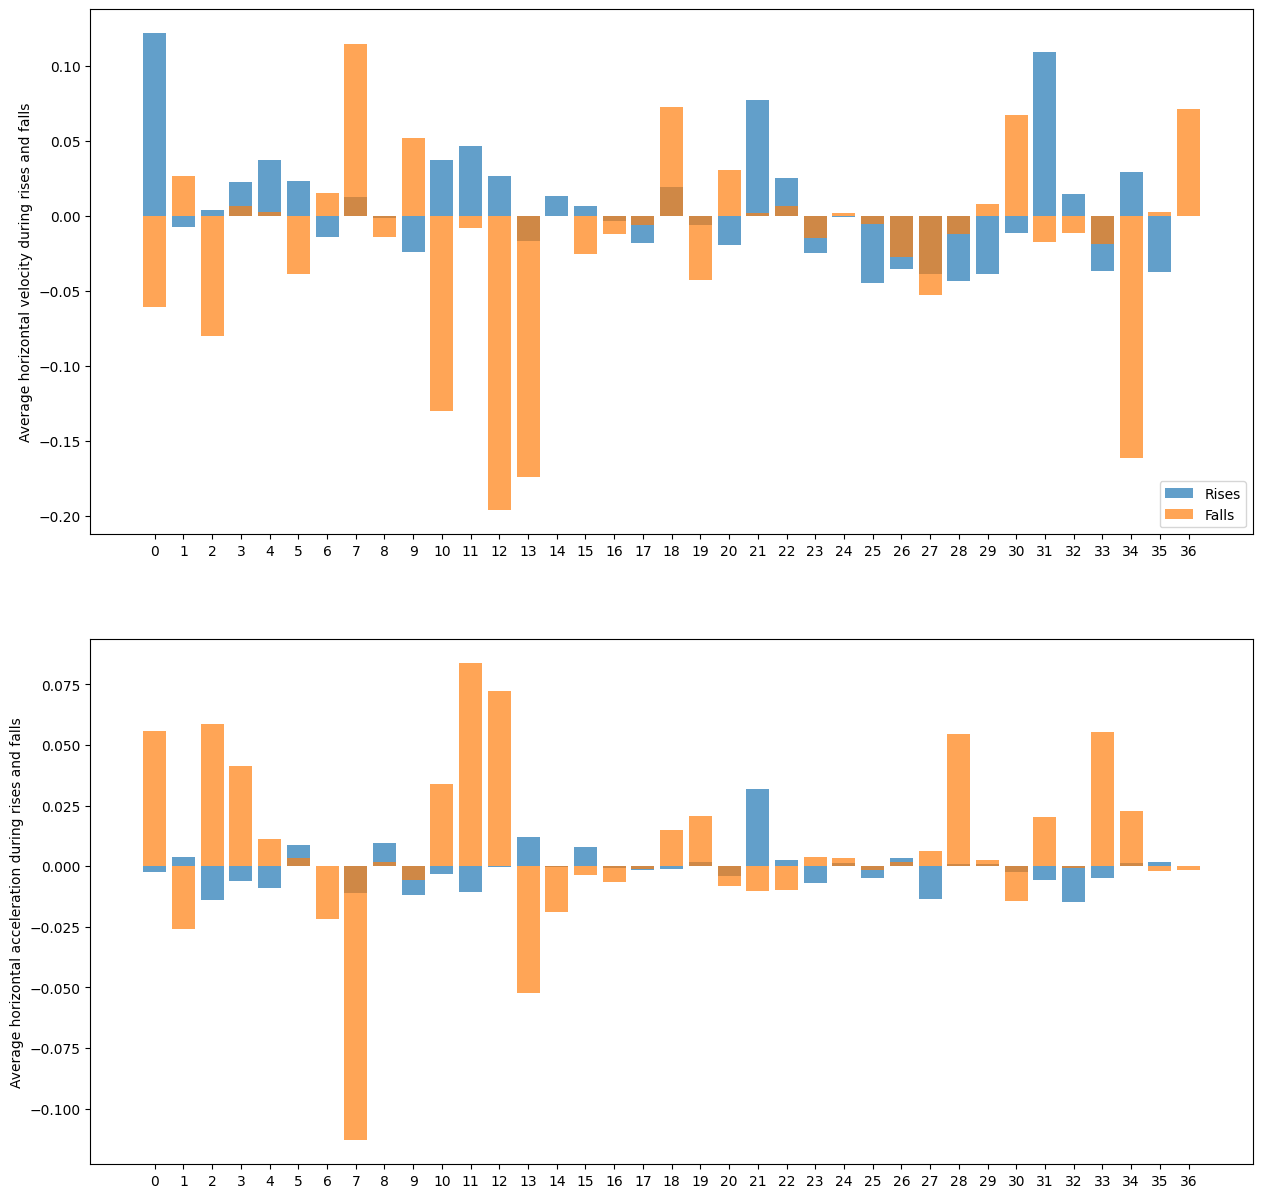

In [25]:
sample = np.arange(0, len(drop3), 30)

segments_down = [np.where((sample > peak3[i]) & (sample < val3[i])) for i in range(len(peak3))]
segments_up = [np.where((sample < peak3[i+1]) & (sample > val3[i])) for i in range(len(peak3)-1)]

vels_up=[np.average([yvel.iloc[i] for i in segments_down[arr]]) for arr in range(len(peak3))]
vels_down = [np.average([yvel.iloc[i] for i in segments_up[arr]]) for arr in range(len(peak3)-1)]

accs_up=[np.average([yacc.iloc[i] for i in segments_down[arr]]) for arr in range(len(peak3))]
accs_down = [np.average([yacc.iloc[i] for i in segments_up[arr]]) for arr in range(len(peak3)-1)]

f, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize = (15, 15))
ax1.bar(np.arange(len(vels_down)), vels_down, alpha = 0.7)
ax1.bar(np.arange(len(vels_up)), vels_up, alpha = 0.7)
ax1.set(ylabel='Average horizontal velocity during rises and falls', 
       xticks=range(len(vels_up)))
ax1.legend(['Rises', 'Falls'], loc='lower right')

ax2.bar(np.arange(len(accs_down)), accs_down, alpha = 0.7)
ax2.bar(np.arange(len(accs_up)), accs_up, alpha = 0.7)
ax2.set(ylabel='Average horizontal acceleration during rises and falls', 
        xticks= range(len(vels_up)))

plt.show()

# Converting to Real World Units
Now that we have all of our data in place, it's time to change units so that our values are actually physically meaningful.

## First trial
Let's convert the velocity values for our first trial to S.I. units and see their distribution again.

In [26]:
vf1 = abs(np.array(vdown1) * 6.104*30*10**(-6)) #Using measured pixel-mm conversion rate
vr1 = abs(np.array(vup1) * 6.104*30*10**(-6))

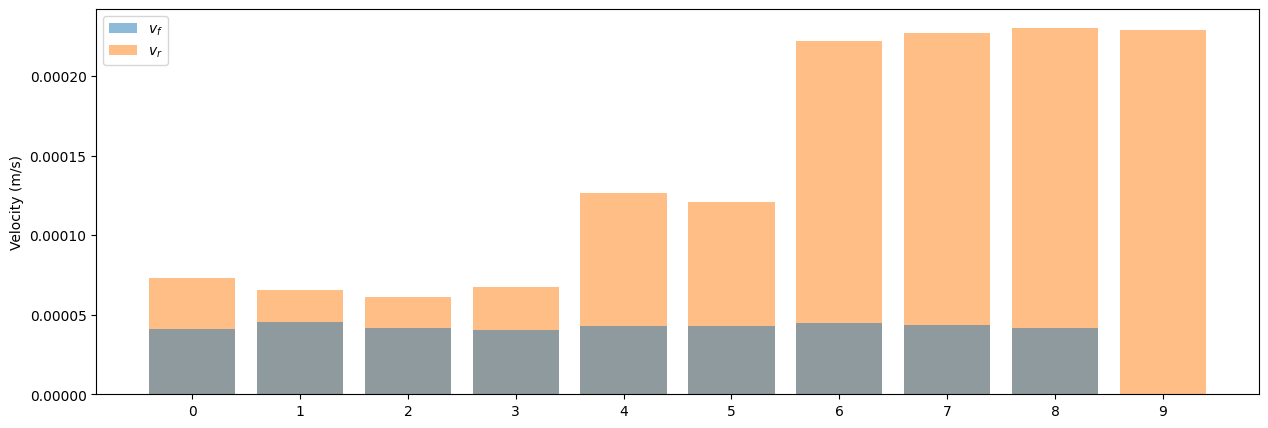

In [27]:
f, ax = plt.subplots(figsize = (15, 5))
ax.bar(np.arange(len(vf1)), vf1, alpha = 0.5)
ax.bar(np.arange(len(vr1)), vr1, alpha = 0.5, zorder=0)
ax.set(ylabel='Velocity (m/s)', xticks=np.arange(len(vr1)))
ax.legend(['$v_f$', '$v_r$'])
plt.show()

Now I will use the charge formula to convert these velocity values into charge values. I'll use the average fall velocity of all the trials to hopefully get a more accurate measurement of $v_f$, but I'll use the individual rising velocities for each charge calculation.

In [28]:
def charge1(vf, vr): 
    b = 8.2*10**(-3)
    p = 101591.4 
    eta = 1.8512 * 10 **(-5) 
    row = 886
    g = 9.81
    d = 0.0075
    V = 500
    
    q = (4*np.pi/3)*((np.sqrt((b/(2*p))**2 + 9*eta*vf/(2*row*g))-b/(2*p))**3)*(row*g*d*(vf+vr))/(V*vf)
    return q

3.03365759178533e-19


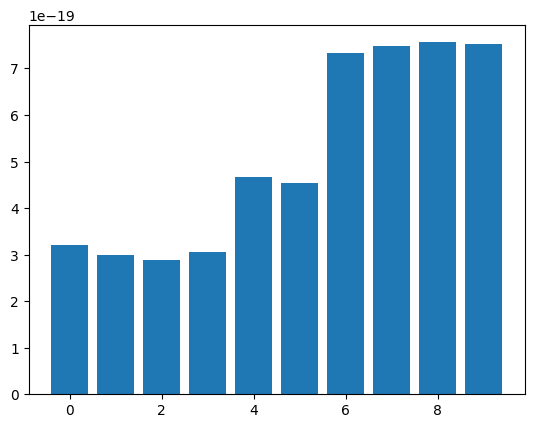

In [29]:
charges1 = np.array([charge1(np.average(vf1), v) for v in vr1])
print(np.average(charges1[charges1 < 4e-19])) # What's the average of my lowest set of values?
f, ax = plt.subplots()
ax.bar(np.arange(len(charges1)), charges1)
plt.show()

I want to find a constant such that all of my charge measurements are clustered around integer multiples of it. I'll do this by defining a residual function to be minimized, `res`, which returns the average squared difference between the charge measurements and their respective nearest integer multiple of $e$, for a given $e$ value. Just from scaling this by hand I know that the optimal value will lie between 1e-19 and 2e-19, so I'll create a range of values between these, spaced 0.001e-19 apart, and use whatever the minimum value is as my $e$ value.

1.5030000000000167e-19


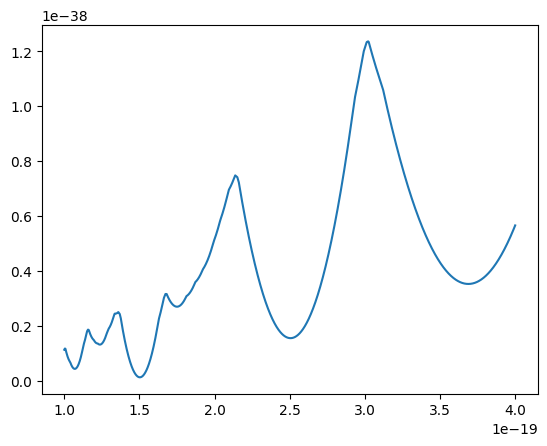

In [30]:
res = lambda elem: np.average(np.array([min([(charge-n*elem)**2 for n in np.arange(15)]) for charge in charges1]))

xrange = np.arange(1e-19, 4e-19, 0.001e-19)
vals = [res(x) for x in xrange]
elem = min(xrange[np.where(vals==min(vals))])
print(elem)
f, ax = plt.subplots()
ax.plot(xrange, [res(x) for x in xrange])
plt.show()

Not bad! Let's see what that does to our histogram.

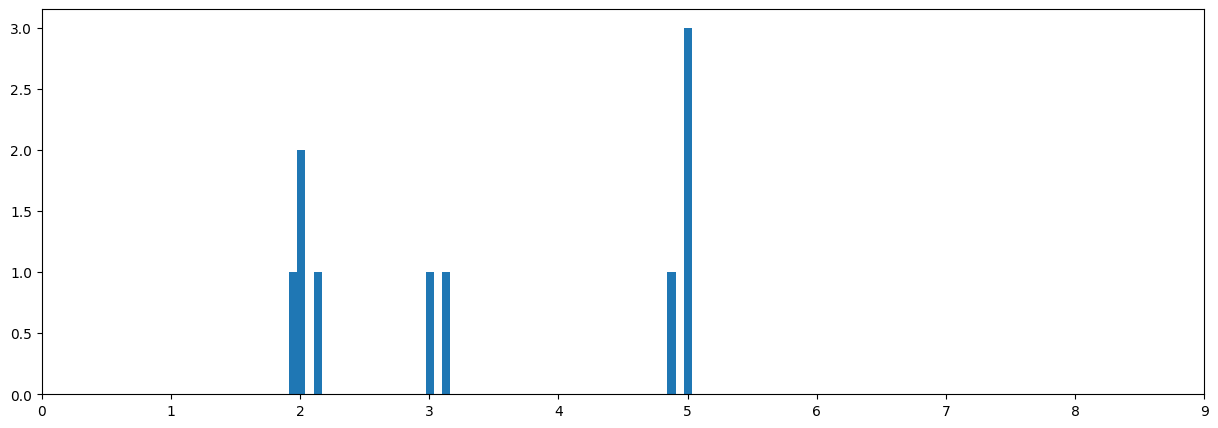

In [31]:
f, ax = plt.subplots(figsize=(15, 5))
ax.hist(charges1/(elem), bins=50, align='mid')
ax.set(xticks=range(10))
plt.show()

Right away we see the expected behaviour. Our charge values are concentrated around integer multiples of some constant $e$. Let's see if we can reproduce this behaviour in our second trial.

## Second Trial

In [32]:
vf2 = abs(np.array(vdown2) * 5.32*30*10**(-6))
vr2 = abs(np.array(vup2) * 5.32*30*10**(-6))

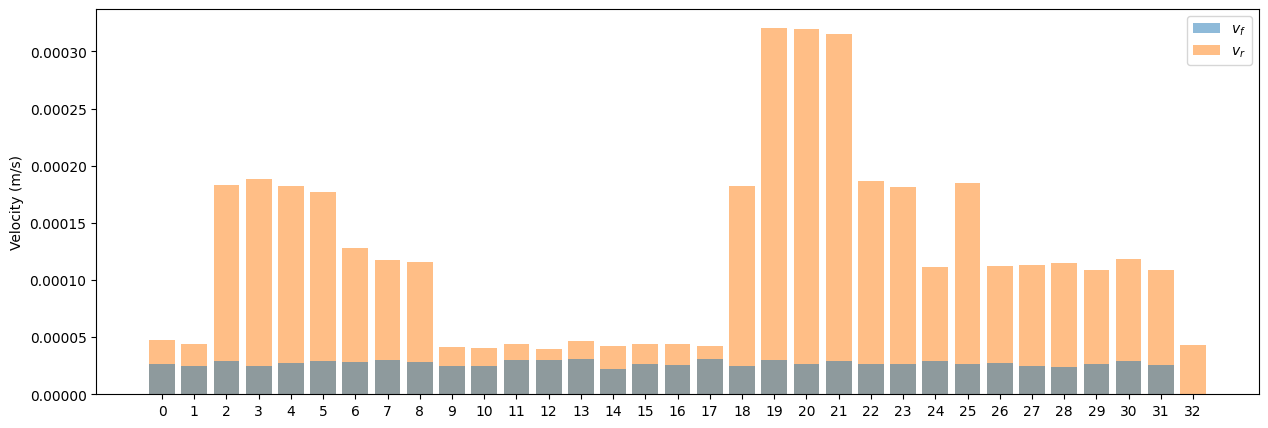

In [33]:
f, ax = plt.subplots(figsize = (15, 5))
ax.bar(np.arange(len(vf2)), vf2, alpha = 0.5)
ax.bar(np.arange(len(vr2)), vr2, alpha = 0.5, zorder=0)
ax.set(ylabel='Velocity (m/s)', xticks=np.arange(len(vr2)))
ax.legend(['$v_f$', '$v_r$'])
plt.show()

In [34]:
def charge2(vf, vr): 
    b = 8.2*10**(-3)
    p = 101591.4 
    eta = 1.8512 * 10 **(-5) 
    row = 886
    g = 9.81
    d = 0.0075
    V = 500
    
    q = (4*np.pi/3)*((np.sqrt((b/(2*p))**2 + 9*eta*vf/(2*row*g))-b/(2*p))**3)*(row*g*d*(vf+vr))/(V*vf)
    return q

1.4873794480638133e-19


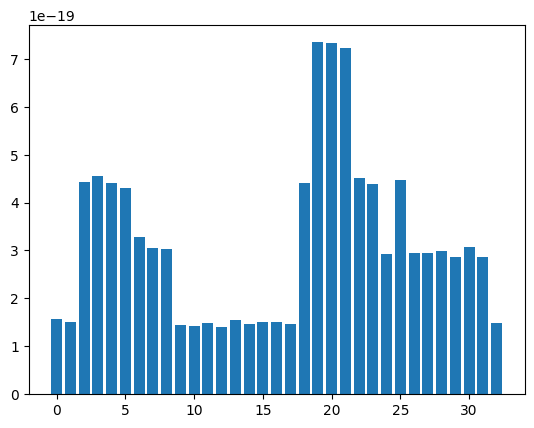

In [35]:
charges2 = np.array([charge2(np.average(vf2), v) for v in vr2])
print(np.average(charges2[charges2 < 2e-19])) # What's the average of my lowest set of values?
f, ax = plt.subplots()
ax.bar(np.arange(len(charges2)), charges2)
plt.show()

Now let's perform the same process as done in the first trial to find the optimal elementary charge value.

1.4760000000000158e-19


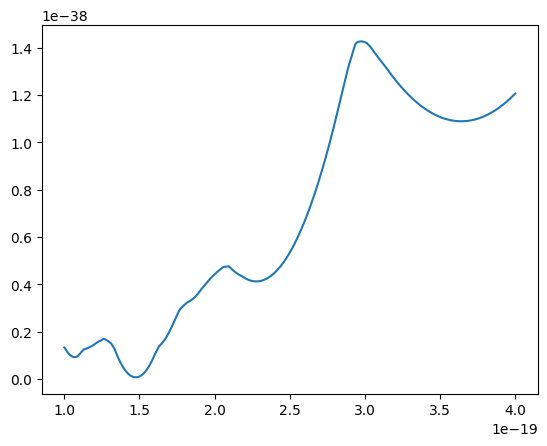

In [36]:
res = lambda elem: np.average(np.array([min([(charge-n*elem)**2 for n in np.arange(15)]) for charge in charges2]))

xrange = np.arange(1e-19, 4e-19, 0.001e-19)
vals = [res(x) for x in xrange]
elem=min(xrange[np.where(vals==min(vals))])
print(elem)
f, ax = plt.subplots()
ax.plot(xrange, [res(x) for x in xrange])
plt.show()

Okay, now let's make a histogram using the calculated value for $e$, `elem`. 

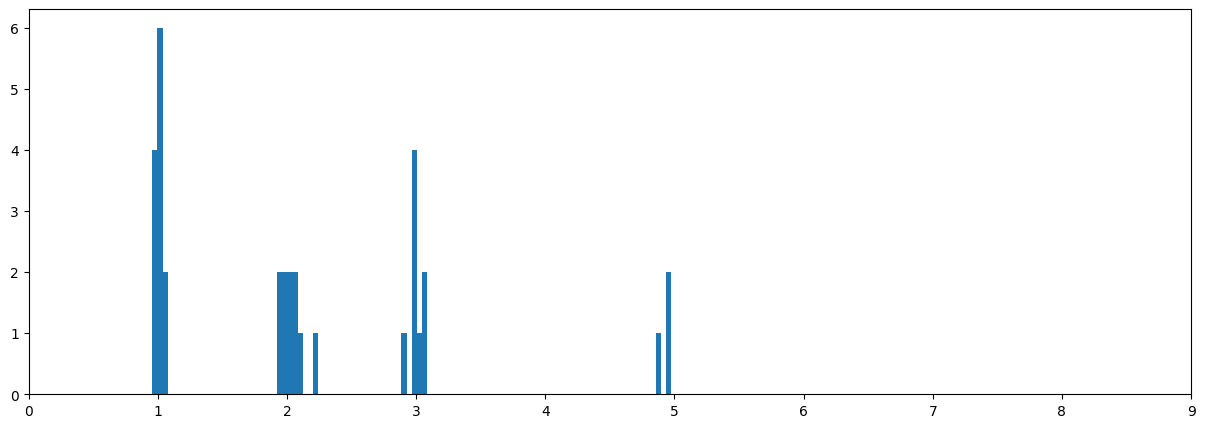

In [37]:
f, ax = plt.subplots(figsize=(15, 5))
ax.hist(charges2/(elem), bins=100, align='mid')
ax.set(xticks=range(10))
plt.show()

Once again we see values clustering around integer multiples of some constant $e$. This is promising, although the calculated $e$ is somewhat lower than expected. Let's move on to trial 3.

## Third trial

In [38]:
vf3 = abs(np.array(vdown3) * 1.9966*10**(-4))
vr3 = abs(np.array(vup3) * 1.9966*10**(-4))

In [39]:
def charge3(vf, vr): 
    b = 8.2*10**(-3)
    p = 101591
    eta = 1.8463 * 10 **(-5) 
    row = 886
    g = 9.81
    d = 0.0075
    V = 500
    
    q = (4*np.pi/3)*((np.sqrt((b/(2*p))**2 + 9*eta*vf/(2*row*g))-b/(2*p))**3)*(row*g*d*(vf+vr))/(V*vf)
    return q

1.5383887350425128e-19


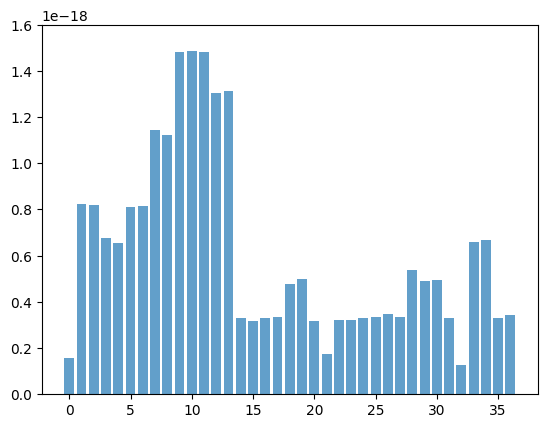

In [40]:
charges3 = np.array([charge3(np.average(vf3), v) for v in vr3])
print(np.average(charges3[charges3 < 0.25e-18])) # What's the average of my lowest set of values?
f, ax = plt.subplots()
ax.bar(np.arange(len(charges3)), charges3, alpha=0.7)
ax.set(ylim=[0, 1.6e-18])
plt.show()

1.6430000000000213e-19


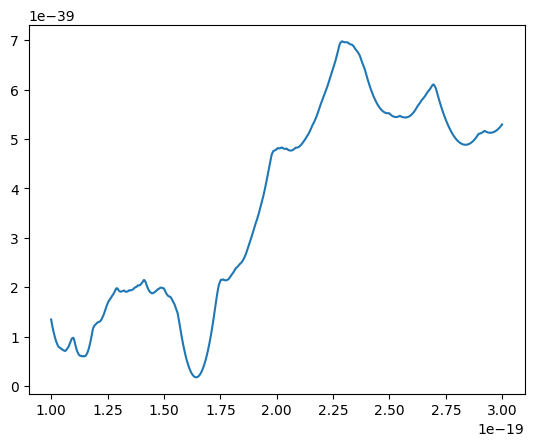

In [41]:
res = lambda elem: np.average(np.array([min([(charge-n*elem)**2 for n in np.arange(15)]) for charge in charges3]))

xrange = np.arange(1e-19, 3e-19, 0.001e-19)
vals = [res(x) for x in xrange]
elem=min(xrange[np.where(vals==min(vals))])
print(elem)
f, ax = plt.subplots()
ax.plot(xrange, [res(x) for x in xrange])
plt.show()

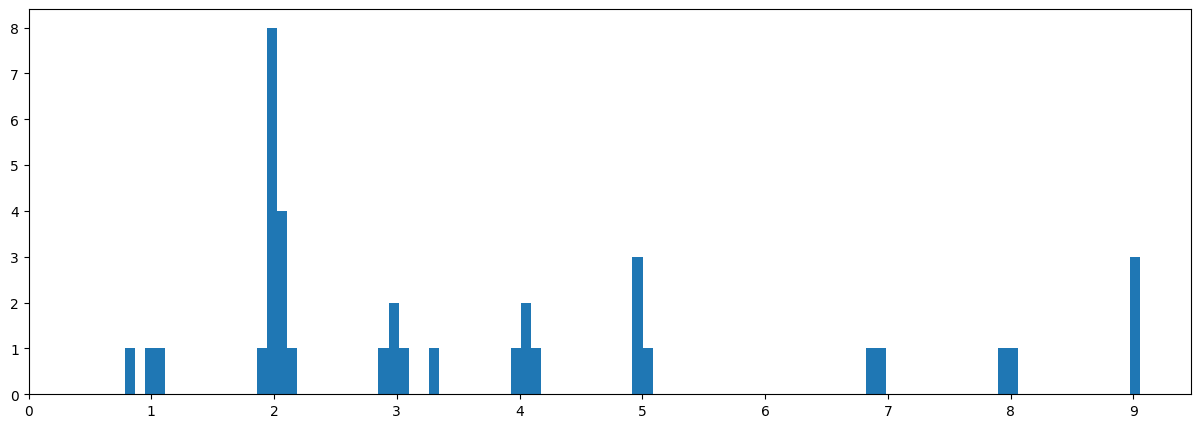

In [42]:
f, ax = plt.subplots(figsize=(15, 5))
ax.hist(charges3/(elem), bins=100, align='mid')
ax.set(xticks=range(10))
plt.show()

We see the same behaviour. Promising! Let's see what we get when we combine the datasets.

## Combined trials

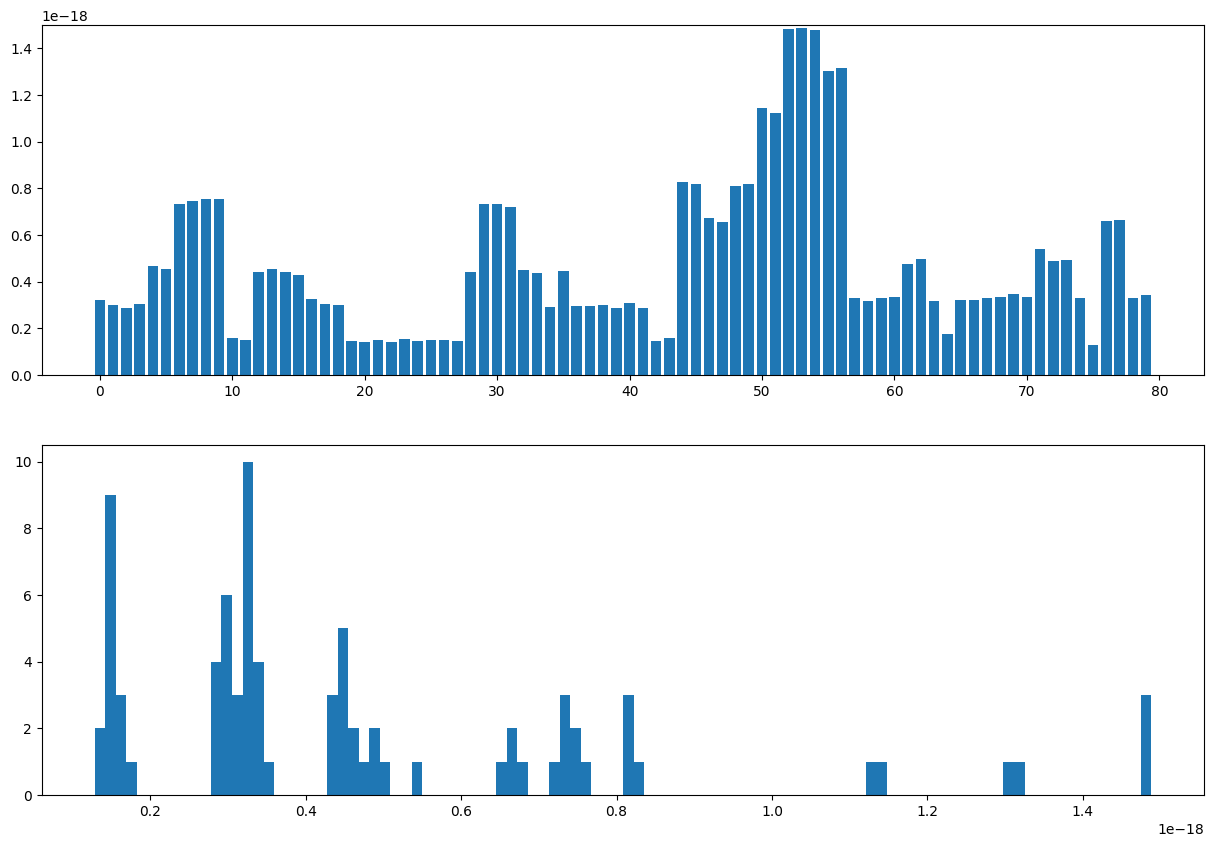

In [43]:
charges = np.concatenate((charges1, charges2, charges3), axis=0)

f, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
ax1.bar(np.arange(len(charges)), charges)
ax1.set(ylim=[0,1.5e-18])
ax2.hist(charges, bins=100)
plt.show()

Elementary charge: 1.5940000000000098e-19
Standard deviation: 2.894331519907418e-20
Standard deviation as percentage of e: 0.18157663236558344


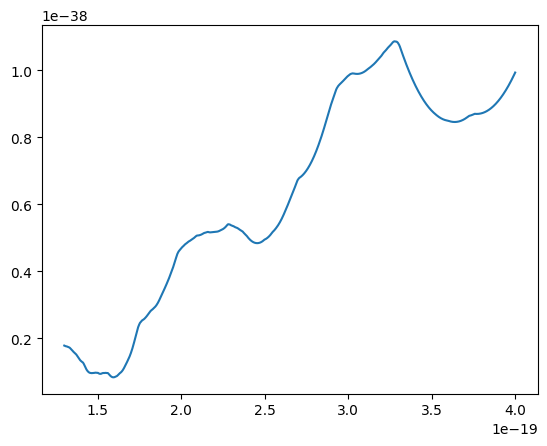

In [44]:
res = lambda elem: np.average(np.array([min([(charge-n*elem)**2 for n in np.arange(30)]) for charge in charges]))

xrange = np.arange(1.3e-19, 4e-19, 0.001e-19)
vals = [res(x) for x in xrange]
print('Elementary charge: {0}'.format(min(xrange[np.where(vals==min(vals))])))
print('Standard deviation: {0}'.format(min(np.sqrt(np.array(vals)))))
print('Standard deviation as percentage of e: {0}'.format(min(np.sqrt(np.array(vals)))/min(xrange[np.where(vals==min(vals))])))
f, ax = plt.subplots()
ax.plot(xrange, [res(x) for x in xrange])
plt.show()

Not a bad result! However that 18% standard deviation is cause for concern. I know my dataset contains some outliers which I did not remove earlier on, so let's see if I can remove some of these to improve this result. I'll look at the deviation for each charge in my dataset and see if there are any that are far enough away from the average to be considered outliers.

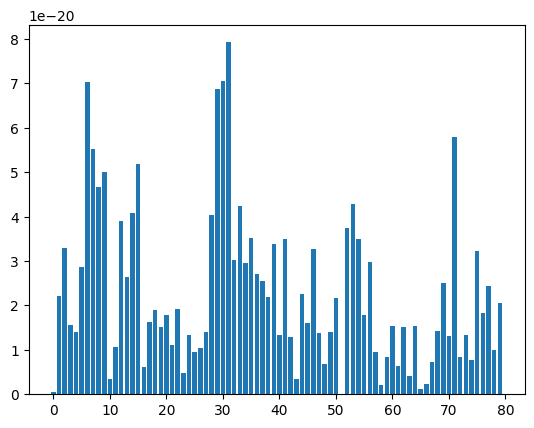

In [45]:
dev = np.sqrt(np.array([min([(charge-n*1.606e-19)**2 for n in np.arange(30)]) for charge in charges]))
plt.bar(range(len(charges)),dev)
plt.show()

It looks like there are about four charge values which deviate from the average much more than is typical. Let's see what happens if we remove the charges who deviate by more than 6e-20.

Elementary charge: 1.6080000000000103e-19
Standard deviation: 2.491095120093395e-20
Standard deviation as percentage of e: 0.15491885075207582


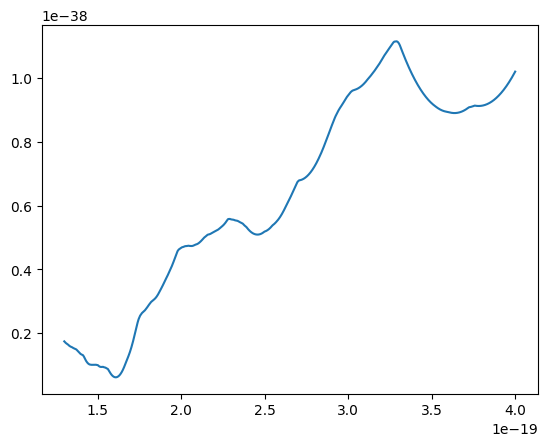

In [46]:
res = lambda elem: np.average(np.array([min([(charge-n*elem)**2 for n in np.arange(30)]) for charge in charges[dev < 6e-20]]))

xrange = np.arange(1.3e-19, 4e-19, 0.001e-19)
vals = [res(x) for x in xrange]
print('Elementary charge: {0}'.format(min(xrange[np.where(vals==min(vals))])))
print('Standard deviation: {0}'.format(min(np.sqrt(np.array(vals)))))
print('Standard deviation as percentage of e: {0}'.format(min(np.sqrt(np.array(vals)))/min(xrange[np.where(vals==min(vals))])))
f, ax = plt.subplots()
ax.plot(xrange, [res(x) for x in xrange])
plt.show()

Awesome. Let's plot our histogram while using this value for $e$. 

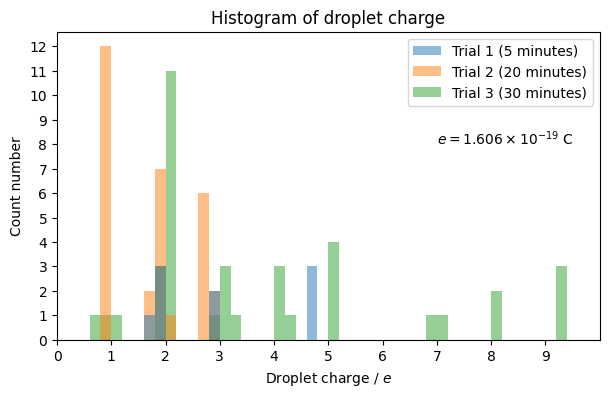

In [47]:
f, ax = plt.subplots(figsize=(7, 4))
num=50
ax.hist(np.delete(charges1, [6])/1.606e-19, bins=num, alpha=0.5, range=(0, 10), zorder=2)
ax.hist(np.delete(charges2, [29-len(charges1),30-len(charges1),31-len(charges1)])/1.606e-19, bins=num, 
        range=(0, 10), alpha=0.5)
ax.hist(charges3/1.606e-19, bins=num, alpha=0.5, range=(0, 10), zorder=0)

ax.set(xticks=np.arange(10), xlim=[0,10], title='Histogram of droplet charge', 
       xlabel=r'Droplet charge / $e$', ylabel='Count number', yticks=range(0,13))
ax.legend(['Trial 1 (5 minutes)', 'Trial 2 (20 minutes)','Trial 3 (30 minutes)'])
ax.text(7, 8, r'$e=1.606 \times 10^{-19}$ C')
plt.show()

Great! We see the expected behaviour. While imperfect, the histogram values spike around integer multiples of our measured $e$ value. 

# Conclusion
In this attempt to reproduce the Millikan experiment, the value of elementary charges was measured to be $1.6 \times 10^{-19} \pm 0.2 \times 10^{-19}$ C, and a histogram was produced which supports the quantization of charge. The measured value was very close the generally accepted value of $e$, $1.602\times 10^{-19}$ C. However, the large standard deviation of the charge measurements from the values predicted by the quantized model indicates a lack of precision which hampers these findings to a degree. This uncertainty could be remedied through a larger sample size, since in this experiment only the motion of three droplets was analyzed. Other possible ways of reducing this uncertainty include monitoring other parameters, such as air viscosity and voltage, with greater precision, and measuring the mass of the oil droplets through a more direct means than Stokes' Law.